For the purpose of this experiment, I've put together a CSV dataset that consists of links to web articles and the labels that were assigned manually during data collection.
In this notebook we will explore the data and preprocess them further for the purpose of training the classifier.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
import transformers
from sklearn.model_selection import train_test_split

from utilities import utils, web_utils

RANDOM_STATE = 5

## Data analysis

In [2]:
data_path = Path('../data/')

article_links = pd.read_csv(data_path/'article_links.csv')
utils.df_summarise(article_links)

(45, 2)

Index(['article_url', 'article_class'], dtype='object')

,article_url,article_class
0,https://www.spglobal.com/marketintelligence/en...,aml_cs
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs
2,https://www.bbc.com/news/business-59689581,aml_aac
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs


As mentioned, the links have been hand labelled. The intention of the model is to achieve the below goals:
1. allow to differentiate between articles related to money laundering activity and those that are not
1. for articles that are related to money laundering, we'd like to know if these pertain to one of the below:
    * allegations / accusations / charges
    * conviction / sentencing

We will be building a deep learning model
Since we will be using a deep learning model, we will aim to achieve these goals in one go

In [3]:
article_links.article_class.value_counts().plot.pie(legend=True);

In [4]:
articles = article_links.copy()
articles['contents'] = articles['article_url'].apply(lambda url: web_utils.get_webpage_body(url))
utils.df_summarise(articles)

(45, 3)

Index(['article_url', 'article_class', 'contents'], dtype='object')

,article_url,article_class,contents
0,https://www.spglobal.com/marketintelligence/en...,aml_cs,\n \n\n \n latest-news-headlines\n ...
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs,\n\n\n\n\nSkip to Main ContentSkip to Search\n...
2,https://www.bbc.com/news/business-59689581,aml_aac,BBC HomepageSkip to contentAccessibility HelpY...
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac,\n\nSkip to main content\nSkip to search box\n...
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs,Accessibility helpSkip to navigationSkip to co...


In [5]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
check_num_of_tokens = lambda row: len(tokenizer(row)['input_ids'])

articles['num_of_tokens'] = articles['contents'].apply(check_num_of_tokens)
utils.df_summarise(articles)

Token indices sequence length is longer than the specified maximum sequence length for this model (2049 > 512). Running this sequence through the model will result in indexing errors


(45, 4)

Index(['article_url', 'article_class', 'contents', 'num_of_tokens'], dtype='object')

,article_url,article_class,contents,num_of_tokens
0,https://www.spglobal.com/marketintelligence/en...,aml_cs,\n \n\n \n latest-news-headlines\n ...,2049
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs,\n\n\n\n\nSkip to Main ContentSkip to Search\n...,3919
2,https://www.bbc.com/news/business-59689581,aml_aac,BBC HomepageSkip to contentAccessibility HelpY...,1438
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac,\n\nSkip to main content\nSkip to search box\n...,2119
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs,Accessibility helpSkip to navigationSkip to co...,2250


count      45.000000
mean     2119.933333
std       921.388882
min      1089.000000
25%      1567.000000
50%      1841.000000
75%      2439.000000
max      5458.000000
Name: num_of_tokens, dtype: float64

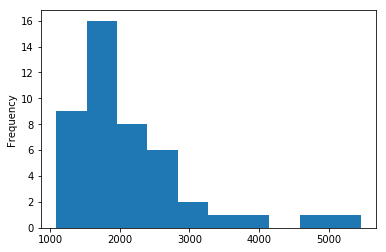

In [9]:
articles['num_of_tokens'].plot.hist()
articles['num_of_tokens'].describe()

## Dataset generation

In [7]:
train, test = train_test_split(
    articles, 
    test_size=0.33, 
    random_state=RANDOM_STATE, 
    shuffle=True, 
    stratify=articles['article_class']
    )
for dataset in [train, test]:
    print('='*60)
    print(dataset.shape)
    print(dataset['article_class'].value_counts())


(30, 4)
aml_cs     10
no_aml     10
aml_aac    10
Name: article_class, dtype: int64
(15, 4)
aml_cs     5
aml_aac    5
no_aml     5
Name: article_class, dtype: int64


In [8]:
train.to_csv(data_path/'train.csv')
test.to_csv(data_path/'test.csv')